In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
covid_pivot =pd.read_parquet("COVID19CovidDataPivot.parquet.gzip")
state_pivot = pd.read_parquet("COVID19StatePivot.parquet.gzip")
covid_panel =pd.read_parquet("COVID19DataForVoila.parquet.gzip")

# Use after fixing format issues for GIS file with data saved
#covid_map_data = gpd.read_parquet("COVID19MapData.parquet")
#covid_map_data.rename(columns = {col: ast.literal_eval(col) for col in covid_map_data.keys() if "("  in col and ")" in col})

In [2]:
state_dict = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ',
    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 
    'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA','Kansas': 'KS', 'Kentucky': 'KY',
    'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

In [3]:
def import_geo_data(filename, index_col = "Date", FIPS_name = "FIPS"):
    # import county level shapefile
    map_data = gpd.read_file(filename = filename,                                   
                                   index_col = index_col)
    # rename fips code to match variable name in COVID-19 data
    map_data.rename(columns={"State":"state"},
                    inplace = True)
    # Combine statefips and county fips to create a single fips value
    # that identifies each particular county without referencing the 
    # state separately
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) + \
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    # set FIPS as index
    map_data.set_index(FIPS_name, inplace=True)
    
    return map_data


In [4]:
map_data = import_geo_data(filename = "countiesWithStatesAndPopulation.shp",
    index_col = "date", FIPS_name= "fips_code")
counties = covid_pivot.index
covid_map_data= map_data.loc[counties]
for key, val in covid_pivot.items():
    covid_map_data[key] = val.astype(np.float64)

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from ipywidgets import *
from ipywidgets.embed import embed_minimal_html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.ticker as mtick

#covid_panel = pd.read_parquet("COVID19DataForVoila.parquet.gzip")

plt.rcParams["font.size"] = 30
class geoPlot():
    def __init__(self, map_data, panel_data, state_data):
        self.interact_map_data = map_data.fillna(0)
        self.state_data = state_data
        self.panel_data = panel_data
        self.keys = ["Total Cases", "Total Deaths",
                     "Deaths per Million", "Cases per Million",
                     "Daily Cases", "Daily Deaths",
                     "Daily Cases 7 Day MA", "Daily Deaths 7 Day MA",
                     "Daily Cases per Million 7 Day MA", "Daily Deaths per Million 7 Day MA"]
        self.dates = self.panel_data.groupby("date").mean().index
        self.states = list(state_dict.keys())
        self.states.insert(0, "United States")
        self.vmax = {key: self.state_data[key].max().max() * 2 for key in self.keys}
        self.county_vmax = {key: self.panel_data[key].max() for key in self.keys}

    def geo_plot(self, date, column, state):
        def view(columns):
            if state != "United States":
                return self.interact_map_data[self.interact_map_data["state"] == state].reset_index().set_index(["state","NAME"])[(columns, date)]
            else:
                return self.interact_map_data.reset_index().set_index(["state", "NAME"])[(columns, date)]
        def setup_cbar():
            self.cmap = cm.get_cmap('Reds', 10)
            norm = cm.colors.Normalize(vmin = 0, vmax = vmax)


            size = "5%" 
            sm = cm.ScalarMappable(cmap=self.cmap, norm=norm)
            # empty array for the data range
            sm._A = []
            # make space for colorbar
            divider = make_axes_locatable(self.ax[1])
            cax = divider.append_axes("right", size = size, pad = 0.1)
            # add colorbar to figure
            cbar = self.fig.colorbar(sm, cax=cax, cmap = self.cmap)
            cbar.ax.tick_params(labelsize=18)
            vals = list(cbar.ax.get_yticks())
            cbar.ax.set_title("Max:" + str(int(self.county_vmax[column])), 
                         va = "bottom", fontsize = 18)
            # format display of values on colorbar
            cbar.ax.yaxis.set_major_formatter(mtick.Formatter())
            # format colorbar values as int
            cbar.ax.set_yticklabels([int(x) for x in vals])
            cbar.ax.set_ylabel(column, fontsize = 20)
        
        vmax = self.vmax[column] if "per Million" in column else self.county_vmax[column]    
        self.fig, self.ax = plt.subplots(2,1, figsize=(16,16))
        setup_cbar()
        self.state_data[column].plot(ax = self.ax[0], legend = False,
                                    color = "k", alpha = .3, linewidth = .5)
        self.ax[0].set_ylim(0)
        self.ax[0].set_title(column + " by State\n" +state + " (Red)\n" + str(date)[:10] , fontsize = 36)
        self.date_line = self.ax[0].axvline(date, linewidth = 3, color = "C0", ls = "--")   
    
        if state == "United States":
            self.state_data[column]["United States"].plot(ax = self.ax[0], legend = False,
                                    color = "C3", alpha = 1, linewidth = 5)
            
            self.interact_map_data[~self.interact_map_data["state"].str.contains(
                "Alaska|Hawaii")].plot(column =  (column, date),
                                       cmap = self.cmap, ax=self.ax[1],
                                       vmin = 0, vmax = vmax)
            self.axins = {}
            self.axins["Alaska"] = inset_axes(self.ax[1], width="17%", height="35%", loc="lower left")
            self.axins["Hawaii"] = inset_axes(self.ax[1], width="50%", height="40%", loc="lower left")
            for st in self.axins.keys():
                self.axins[st].set_xticks([])
                self.axins[st].set_yticks([])
                self.axins[st].axis("off")
                self.interact_map_data[self.interact_map_data["state"].str.contains(st)].plot(
                    column = (column,date),  ax = self.axins[st], cmap = self.cmap, 
                    vmin = 0, vmax = self.vmax[column])
            
            self.axins["Hawaii"].set_xlim(-161, -155)
            self.axins["Alaska"].set_ylim(53, 71)
        else:
            self.interact_map_data[self.interact_map_data[
                "state"] ==state].plot(column =  (column,date), 
                                                 cmap = self.cmap, ax=self.ax[1],
                                                 vmin = 0, vmax = vmax)
            self.state_data[column, state].plot(ax = self.ax[0], legend = False,
                                    color = "C3", alpha = 1, linewidth = 5)
        self.ax[0].set_xlabel("")
        view_cols = Select(options = self.keys)
        interact(view, columns = view_cols)
        

interactive_map = geoPlot(covid_map_data, 
                          covid_panel, 
                          state_pivot)

interact(interactive_map.geo_plot, 
         date = interactive_map.dates,
         column = interactive_map.keys,
         state = interactive_map.states)


interactive(children=(Dropdown(description='date', options=(Timestamp('2020-01-22 00:00:00'), Timestamp('2020-…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Text(0, 0.5, 'Daily Deaths per Million 7 Day MA')

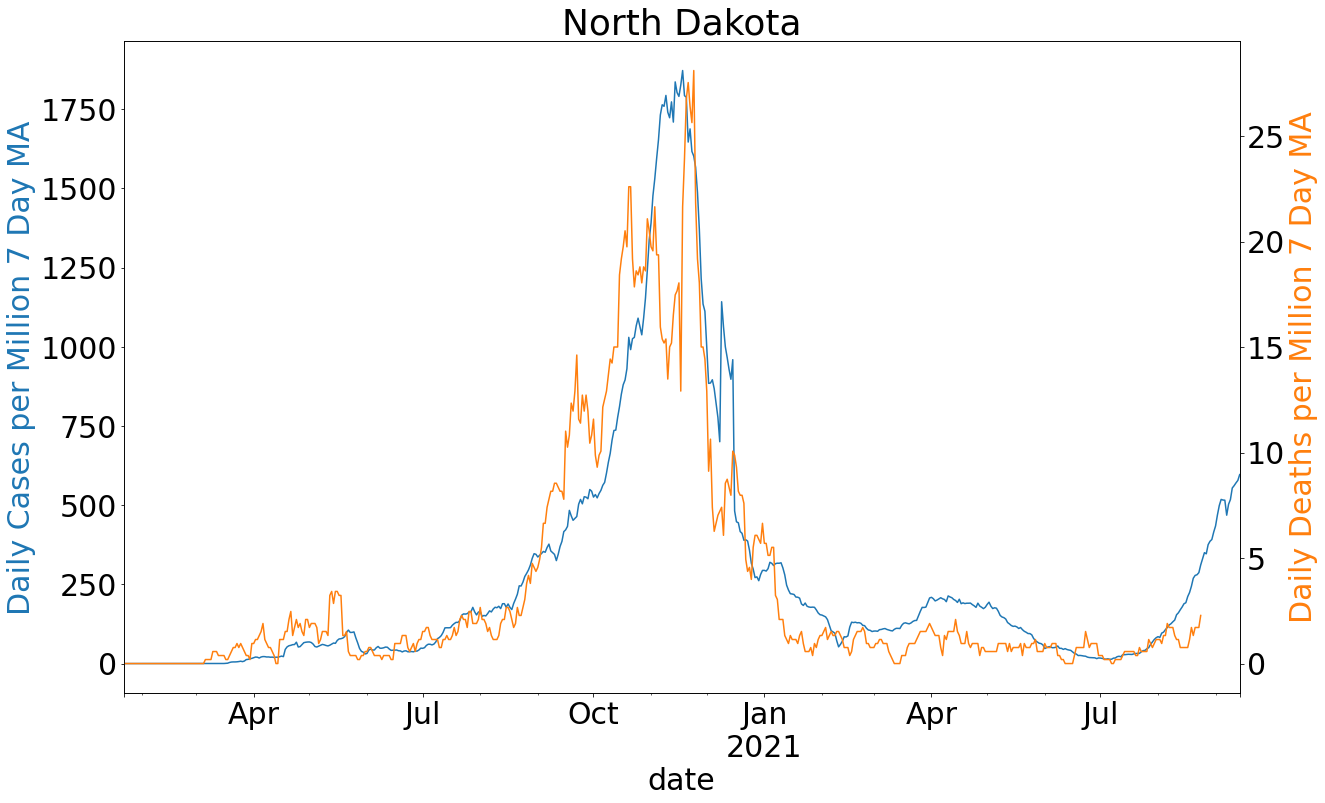

In [6]:
fig, ax = plt.subplots(figsize = (20,12))
ax2 = ax.twinx()
state_pivot[
    [("Daily Cases per Million 7 Day MA", "North Dakota")]].plot.line(legend = False, 
                                                                      secondary_y = False,
                                                                      ax = ax) 
state_pivot[[("Daily Deaths per Million 7 Day MA", "North Dakota")]].shift(-21).plot.line(legend = False,
                                                                               color = "C1",
                                                                               ax = ax2)
plt.title("North Dakota")
ax.set_ylabel("Daily Cases per Million 7 Day MA", color = "C0")
ax2.set_ylabel("Daily Deaths per Million 7 Day MA", color = "C1")


Text(0, 0.5, 'Daily Deaths per Million 7 Day MA')

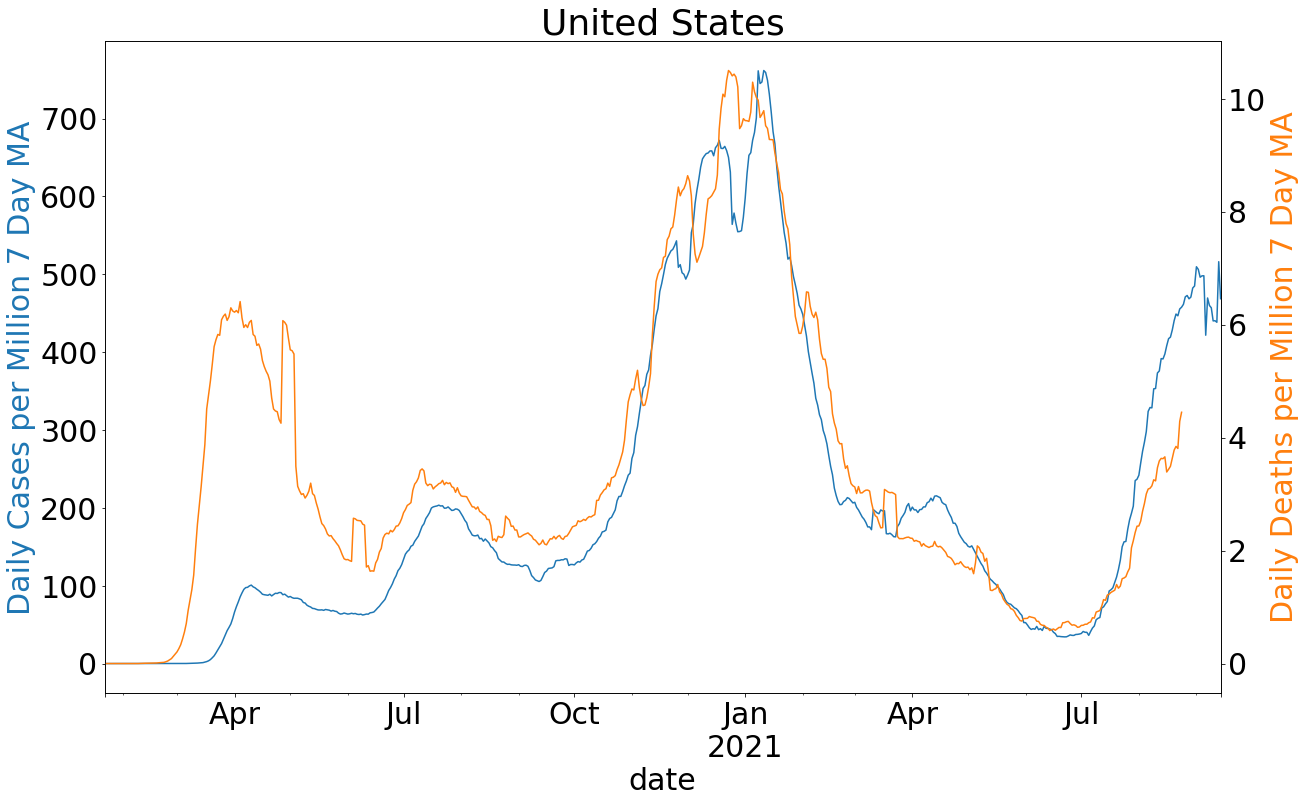

In [7]:
fig, ax = plt.subplots(figsize = (20,12))
ax2 = ax.twinx()
state_pivot[
    [("Daily Cases per Million 7 Day MA", "United States")]].plot.line(legend = False, 
                                                                      secondary_y = False,
                                                                      ax = ax) 
state_pivot[[("Daily Deaths per Million 7 Day MA", "United States")]].shift(-21).plot.line(legend = False,
                                                                               color = "C1",
                                                                               ax = ax2)
plt.title("United States")
ax.set_ylabel("Daily Cases per Million 7 Day MA", color = "C0")
ax2.set_ylabel("Daily Deaths per Million 7 Day MA", color = "C1")


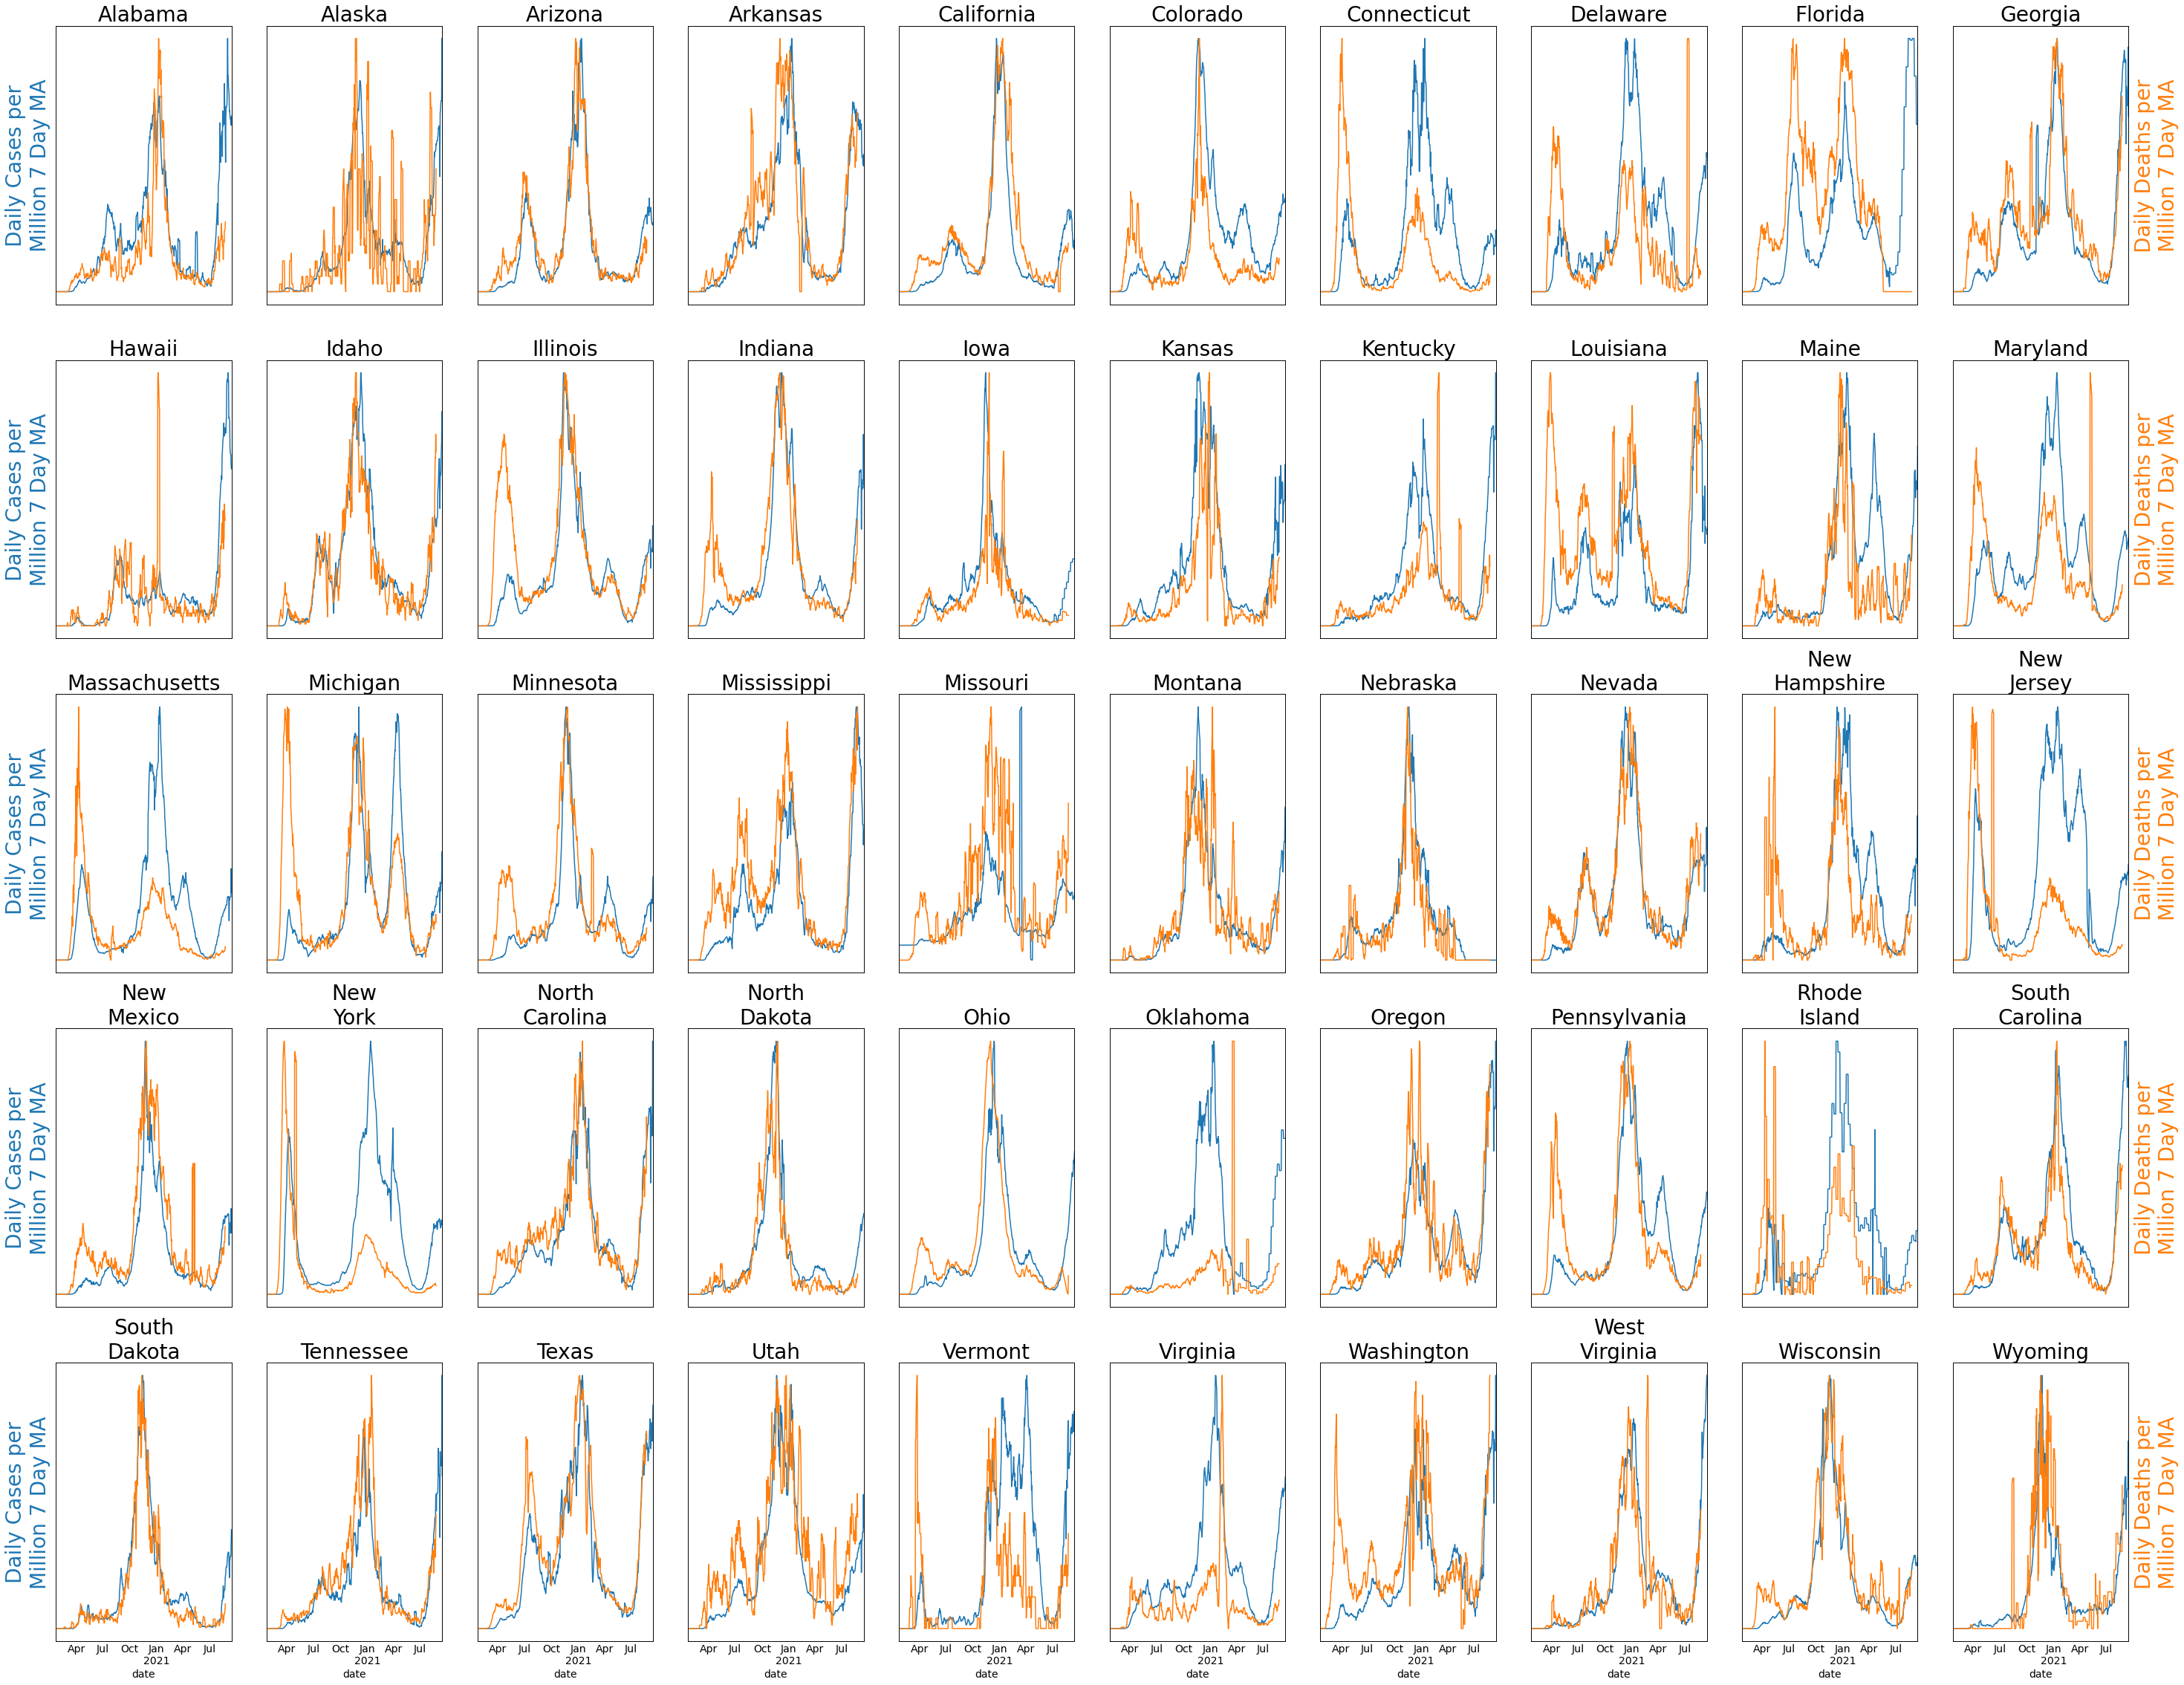

In [8]:
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(5,10,figsize = (50,40))
i = 0
j = 0
states = list(state_dict.keys())
for state in states:
    if state == "District of Columbia":
        continue
    a = ax[j][i]
    a.tick_params(axis=u'both', which=u'both',length=0)
    
    a2 = a.twinx()
    a2.tick_params(axis=u'both', which=u'both',length=0)

    state_pivot[
        [("Daily Cases per Million 7 Day MA", state)]].plot.line(legend = False, 
                                                                  secondary_y = False,
                                                                  ax = a) 
    state_pivot[("Daily Deaths per Million 7 Day MA", state)][state_pivot[("Daily Deaths per Million 7 Day MA", state)] < 0] = 0

    state_pivot[[("Daily Deaths per Million 7 Day MA", state)]].shift(-21).plot.line(legend = False,
                                                                                   color = "C1",
                                                                                   ax = a2)
    plt.title(state.replace(" ", "\n"), fontsize = 28)
    if i == 0:
        a.set_ylabel("Daily Cases per\nMillion 7 Day MA", color = "C0", fontsize =28)
    if i == 9:
        a2.set_ylabel("Daily Deaths per\nMillion 7 Day MA", color = "C1", fontsize = 28)
    a.set_yticklabels([])
    a2.set_yticklabels([])
    if j < 4:
        a.set_xticklabels([])
        a2.set_xticklabels([])
        a.set_xlabel("")
        a2.set_xlabel("")

    i +=1

    if i == 10:
        i = 0
        j +=1
plt.show()
plt.close()